**TRPO** (Trust Region Policy Optimization), is a very powerful Policy Gradient method that guarantees monotonic updates to the value if some conditions are met. In order to do that, it uses an actor-critic architecture, where the critic is updated using standard techniques (similar to A2C, for instance), but the actor has a more involved update. In DDPG, **the state and the actions can be continuous and/or discrete**.

In order to update the actor, TRPO solves the following optimization problem:
$$
\begin{array}{ccc}
\phi_{k+1}= & \arg\max & \mathbb{E}_{s,a\sim\pi_{\phi_{k}}}\Big[\frac{\pi_{\phi}(a|s)}{\pi_{\phi_{k}}(a|s)}A^{\pi_{\phi_{k}}}(s,a)\Big]\\
 & s.t.: & \mathbb{E}_{s\sim\pi_{\phi_{k}}}\Big[D_{KL}(\pi_{\phi}(\cdot|s)||D_{KL}(\pi_{\phi_{k}}(\cdot|s)\text{\ensuremath{\Big]}}\leq\delta
\end{array}
$$
where $\pi$ is the policy, $\phi$ are the parameters of the policy network, $A$ is the advantage function, $D_{KL}$ is the Kullback-Leibler divergence, and $\delta$ is a threshold. Note that the update simply means that we are maximizing the probability of actions that yield a high advantage (and minimizing the probability of the actions that yield a low one), but at the same time, the new policy cannot be too *far away* from the previous one in terms of Kullback-Leibler divergence. This means that TRPO imposes a restriction on the maximum variation, thus trying to learn with security.

However, that optimization problem is difficult to solve, so TRPO makes use of the following procedure:
* First, by using a Taylor expansion, the previous problem is posed as:
$$
\begin{array}{ccc}
\phi_{k+1}= & \arg\max & g^{T}(\phi-\phi_{k})\\
 & s.t.: & \frac{1}{2}(\phi-\phi_{k})^{T}H(\phi-\phi_{k})\leq\delta
\end{array}
$$
 where $g$ is the Policy Gradient and $H$ is the Fisher information matrix of the policy. This problem has an analytical solution by using Lagrangian methods: $\phi_{k+1}=\phi_{k}+\sqrt{\frac{2\delta}{g^{T}H^{-1}g}}H^{-1}g$.
* The Taylor expansion may cause that the Kullback-Leibler restriction is not fulfilled, so TRPO uses backtracking as:
$$
\phi_{k+1}=\phi_{k}+\alpha^{j}\sqrt{\frac{2\delta}{g^{T}H^{-1}g}}H^{-1}g
$$
 where $\alpha \in (0, 1)$ and we select $j$ as the smallest integer that fulfills the Kullback-Leibler constrain.
* Since $H$ is a large matrix, and its inversion may be unfeasible, Conjugate Gradient is used to obtain $H^{-1} g$ efficiently.

This complex update requires a significant load of computational resources: note that we are using second order information to update (the Fisher Information Matrix). The authors of TRPO also released an approximation that uses only first order information and that is computationally lighter, which has become very popular as well: PPO (Proximal Policy Optimization).

In this case, for the code, we are taking a different approach: instead of implementing TRPO, we are going to use a state-of-the-art implementation so that you can see how to use it.

We have chosen Stable Baselines 3, so you can see how you could use these codes for your own projects.

As usual, we first start by installing required packages and importing what we need.



In [56]:
!pip install stable_baselines3
!pip install sb3-contrib
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from sb3_contrib import TRPO
from stable_baselines3.common.logger import configure
import os
import pandas as pd
%matplotlib inline

A known problem of DRL are the reproducibility issues (see Henderson, P., Islam, R., Bachman, P., Pineau, J., Precup, D., & Meger, D. (2018, April). Deep reinforcement learning that matters. In Proceedings of the AAAI conference on artificial intelligence (Vol. 32, No. 1), https://doi.org/10.48550/arXiv.1709.06560).

To prevent that, the code is seeded: note that changing the seed will change the results, as DRL is known to be extremely sensitive to the initial conditions.

In [57]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

We are finally ready! Now, we can train our agent and see what they learn. In order to show the differences between seeds, we are going to run $3$ different initial seeds: in this case, note that TRPO is *very* stable, regardless of the initial seed.

Also, note that we could modify all these parameters in the TRPO model (you may play around and see what they do).
* policy: either a string for predefined policies, or a custom model.
* env: either a string for a model from Gym, or a custom environment.
* learning_rate: Union[float, Schedule] = 1e-3: the learning rate for the optimizer.
* n_steps: int = 2048.
* batch_size: int = 128.
* gamma: float = 0.99: discount factor.
* cg_max_steps: int = 15: maximum number of steps in the Conjugate Gradient algorithm (higher is better, but increases computational load).
* cg_damping: float = 0.1: damping factor for Conjugate Gradient.
* line_search_shrinking_factor: float = 0.8: the $\alpha$ value above.
* line_search_max_iter: int = 10: the maximum $j$ value above.
* n_critic_updates: int = 10: number of times that the critic is updated per update.
* gae_lambda: float = 0.95: Generalized Advantage Estimator (GAE) parameter, that controls whether the estimator trades bias for variance.
* use_sde: bool = False.
* sde_sample_freq: int = -1.
* normalize_advantage: bool = True: wheter to normalize the advantages.
* target_kl: float = 0.01: the $\delta$ value above.
* sub_sampling_factor: int = 1.
* stats_window_size: int = 100: sliding window to average statistics.
* tensorboard_log: Optional[str] = None.
* policy_kwargs: Optional[Dict[str, Any]] = None.
* verbose: int = 0.
* seed: Optional[int] = None: seed to have repeatable results.
* device: Union[th.device, str] = "auto": where to train (CPU, GPU).


In [58]:
# Create and train the agent several times and plot the results
trials = 3
scores, iterations, vlosses, pobjectives = [], [], [], []

for i in range(trials):
    print("Trial {}/{}".format(i + 1, trials))
    # Create the agent: see https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/master/sb3_contrib/trpo/trpo.py
    new_logger = configure(os.path.join(os.getcwd(), 'tmp'), ["stdout", "csv"])  # STDOUT: command line output, CSV: to save the results
    model = TRPO("MlpPolicy", 'CartPole-v1', verbose=1, seed=i, device='cpu')
    model.set_logger(new_logger)
    model.learn(total_timesteps=100_000, log_interval=1)
    results = pd.read_csv(os.path.join(os.getcwd(), 'tmp', 'progress.csv'))  # The results are logged as CSV, we load them to show the results
    iterations.append(results['time/iterations'].tolist())
    scores.append(results['rollout/ep_rew_mean'].tolist())
    vlosses.append(results['train/value_loss'].tolist())
    pobjectives.append(results['train/policy_objective'].tolist())


Trial 1/3
Logging to /content/tmp
Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 21.6     |
| time/              |          |
|    fps             | 632      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 27.5     |
|    ep_rew_mean            | 27.5     |
| time/                     |          |
|    fps                    | 469      |
|    iterations             | 2        |
|    time_elapsed           | 8        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | -0.00116 |
|    is_line_search_succes

Now, we plot the results: note that some seeds learn, and others do not, just because of the seed. Thus, it is good practice in DRL to run an algorithm several times, over 8-10 seeds, and then average the results of the best 3-5 seeds.

Note how, in this case, TRPO is **very** stable, and the monotonic gain in value is fulfilled.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


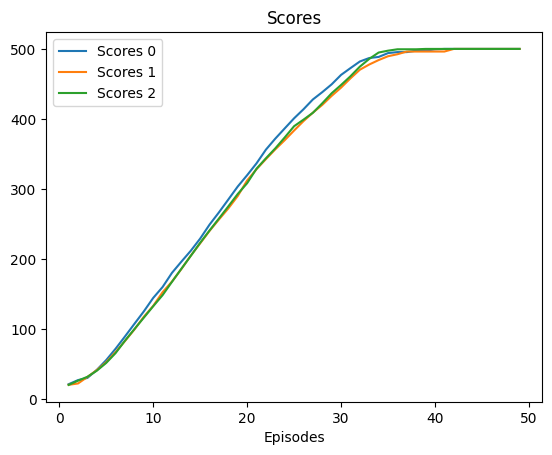

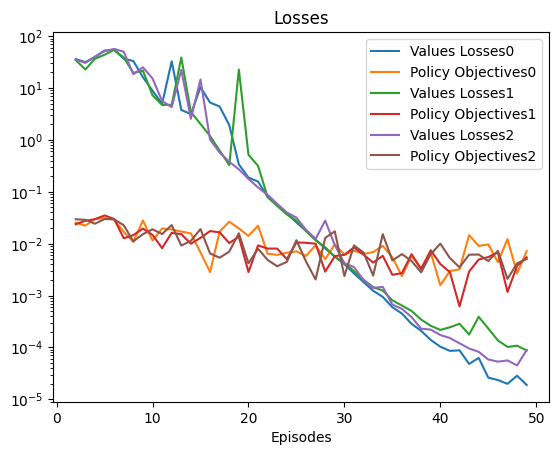

In [59]:
# Plot the scores and losses vs the episodes
fig, ax1 = plt.subplots()
for i in range(trials):
    ax1.plot(iterations[i], scores[i], label='Scores ' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Scores')
plt.show()

fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.semilogy(iterations[i], vlosses[i], label='Values Losses' + str(i))
    ax1.semilogy(iterations[i], pobjectives[i], label='Policy Objectives' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Losses')
plt.show()

Finally, we will visualize the learned policy.

Obtaining data from trained network
Data obtained
Creating animation


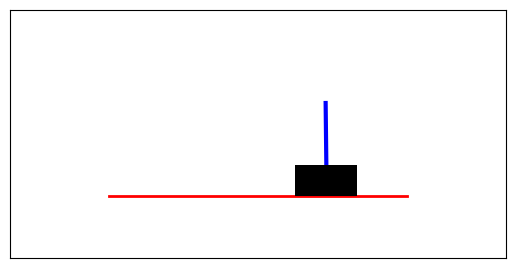

In [60]:
# Run the game once with the trained network and store the values of the position and angle of the cartpole
print("Obtaining data from trained network")
import gymnasium as gym
env = gym.make('CartPole-v1')
pos_vector=[]
angle_vector=[]
state, _ = env.reset()
state = np.reshape(state, [1, env.observation_space.shape[0]])
done=False
while not done:
    pos_vector.append(state[0,0])
    angle_vector.append(state[0,2])
    action = model.predict(state)[0].item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
    state = next_state
    if done:
        break
T=len(pos_vector)
print("Data obtained")

# Animate the data: to observe what our network has learned
from matplotlib import animation, patches
from IPython.display import HTML
print("Creating animation")
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 3), aspect=1)
ax.set_xticks([])
ax.set_yticks([])

mag1 = plt.Rectangle((0,0), width= 1, height= 0.5, angle=0, fc='black', alpha=0)
line1, = ax.plot([], [], 'b', zorder=1,linewidth=3.0)
line2, = ax.plot([], [], 'r', zorder=1,linewidth=2.0)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.add_patch(mag1)
    return mag1, line1, line2,

def animate(i):
    mag1.set_alpha(1)
    mag1.xy = (pos_vector[i],0)
    x0=pos_vector[i]+0.5
    y0=0.5
    x1=x0+np.cos(np.pi/2-angle_vector[i])
    y1=y0+np.sin(np.pi/2-angle_vector[i])
    line1.set_data([x0, x1], [y0, y1])
    line2.set_data([-2.4, 2.4], [0,0])
    return mag1, line1, line2,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T,
                               interval=25, blit=True)

HTML(anim.to_jshtml())